# Cleaned up some...

In [0]:
import numpy as np
import pandas as pd
import requests, zlib
from sklearn.utils import shuffle
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

# get data

'''
The directory contains two files each consisting the headlines of 16,000 articles.
Both files are compressed using gzip, and each line in the decompressed files contains one article headline. 
The clickbait corpus consists of article headlines from ‘BuzzFeed’, ‘Upworthy’, ‘ViralNova’, ‘Thatscoop’, ‘Scoopwhoop’ and ‘ViralStories’. 
The non-clickbait article headlines are collected from ‘WikiNews’, ’New York Times’, ‘The Guardian’, and ‘The Hindu’.
This dataset is an enlarged version of the dataset used in the following paper. 
If you are using this data for any research publication, or for preparing a technical report, you must cite the paper as the source of the dataset.
Abhijnan Chakraborty, Bhargavi Paranjape, Sourya Kakarla, and Niloy Ganguly. 
"Stop Clickbait: Detecting and Preventing Clickbaits in Online News Media”. 
In Proceedings of the 2016 IEEE/ACM International Conference on Advances in Social Networks Analysis and Mining (ASONAM), San Fransisco, US, August 2016.
'''

res = requests.get('https://github.com/bhargaviparanjape/clickbait/raw/master/dataset/clickbait_data.gz')
data = zlib.decompress(res.content, zlib.MAX_WBITS|32)
data = data.decode("utf-8").split('\n')
clickbait = data[:-1]
df = pd.DataFrame(clickbait)

res2 = requests.get('https://github.com/bhargaviparanjape/clickbait/raw/master/dataset/non_clickbait_data.gz')
data2 = zlib.decompress(res2.content, zlib.MAX_WBITS|32)
data2 = data2.decode("utf-8").split('\n')
non_clickbait = data2[:-1]
df2 = pd.DataFrame(non_clickbait)

# get more data from different source

'''
Data from https://clickbait-challenge.org
'''

instances = pd.read_json('https://raw.githubusercontent.com/Lambda-School-Labs/DS-GoodNews/master/instances.jsonl', lines=True)
truth = pd.read_json('https://raw.githubusercontent.com/Lambda-School-Labs/DS-GoodNews/master/truth.jsonl', lines=True)

instances = instances[['id', 'targetTitle']]
truth = truth[['id', 'truthClass']]

In [0]:
# add columns containing 0/1 for non_clickbait and clickbait

df.columns = ['text']
df['isClickbait'] = ['1' for _ in range(len(clickbait))]

df2.columns = ['text']
df2['isClickbait'] = ['0' for _ in range(len(non_clickbait))]

# Two datasets are merged and truth class is changed from
# 'no-clickbait' to '0' and from 'clickbait' to '1'.

df3 = pd.merge(instances, truth, on = 'id')
df3['isClickbait'] = df3['truthClass'].map({'no-clickbait': '0', 'clickbait': '1'})
df3 = df3[['targetTitle', 'isClickbait']]
df3.columns = ['text', 'isClickbait']

In [0]:
# drop badly parsed data ...

df3 = df3[~df3['text'].str.contains('Sections Shows Live Yahoo!-ABC News Network')]

In [56]:
# shuffle before dividing into training and testing sets to mix up clickbait
# and non-clickbait samples.
# Drop rows containing nan and empty values.

data = pd.concat([df, df2, df3])
data = shuffle(data)
data.reset_index(inplace = True)
data = data[['text', 'isClickbait']]
print(len(data))
data.replace('', np.NaN, inplace = True)
data.dropna(inplace = True)
print(len(data))

60354
34353


In [57]:
# initialize train-test split at 75% of data

split = int(len(data)*0.75)
print(split)

# assign training and test sets

X_train0 = data['text'][:split].values
y_train = data['isClickbait'][:split].values
X_test0 = data['text'][split:].values
y_test = data['isClickbait'][split:].values

# convert input values into a matrix of TF-IDF features

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train0)
X_test = vectorizer.transform(X_test0)

25764


In [58]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier as ABC
from sklearn.naive_bayes import MultinomialNB as MNB
from sklearn.neural_network import MLPClassifier as MLPC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RFC

from sklearn.metrics import accuracy_score

models = {'Linear Support Vector': LinearSVC(),
          'Multi-layer Perceptron': MLPC(max_iter = 8),
          'Multinomial Naive Bayes': MNB(),
          'Logistic Regression': LR(),
          'Adaptive Boosting': ABC(n_estimators = 1000),
          'Random Forest': RFC(n_estimators = 100)}

p = []
for n, m in models.items():
  m.fit(X_train, y_train)
  predictions = m.predict(X_test)
  p.append(predictions)
  print('%s : %.3f' % (n, accuracy_score(y_test, predictions)))

Linear Support Vector : 0.954
Multi-layer Perceptron : 0.955
Multinomial Naive Bayes : 0.952
Logistic Regression : 0.949
Adaptive Boosting : 0.935
Random Forest : 0.941


c: 41, t: 20, accuracy: 0.958


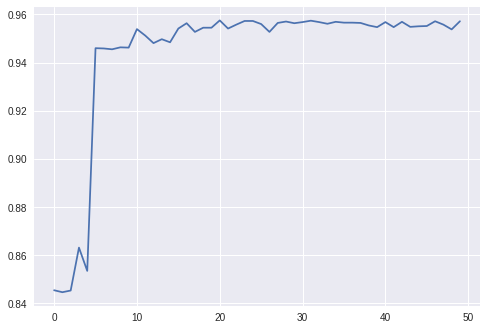

In [59]:
import matplotlib.pyplot as plt

# By tuning hyperparameters, the accuracy of SVC can be improved by ~ 0.003

acc = []
best = (0,0,0)

for c in range(1,100, 10):
  for t in range(20, 30, 2):
    model = LinearSVC(C = c/100, loss = 'hinge', tol = t/10)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    a = accuracy_score(y_test, predictions)
    acc.append(a)
    if a > best[2]: best = (c, t, round(a,3))

print('c: %d, t: %d, accuracy: %.3f' % best) 
  
plt.plot(acc);
plt.show()

a: 46, accuracy: 0.954


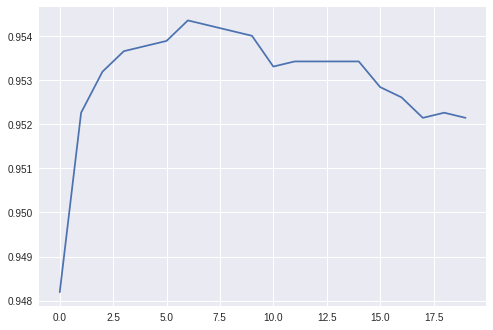

In [61]:
# By tuning hyperparameters, the accuracy of MNB can be improved by ~ 0.004

acc = []
best = (0,0)

for a in range(1,100,5):
  model = MNB(alpha = a/100)
  model.fit(X_train, y_train)
  predictions = model.predict(X_test)
  ac = accuracy_score(y_test, predictions)
  acc.append(ac)
  if ac > best[1]: best = (a, round(ac,3))

print('a: %d, accuracy: %.3f' % best) 
  
plt.plot(acc);
plt.show()

1 0.9598323436954244
2 0.9620444754919083
3 0.9594830597275585
4 0.9614623355454651
n: 2, accuracy: 0.962


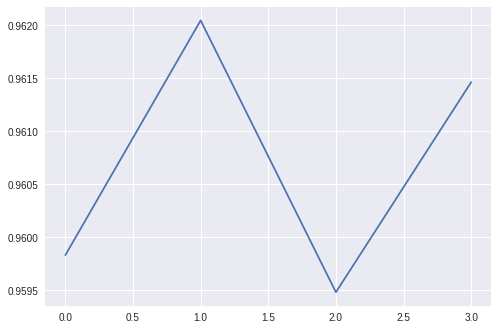

In [62]:
# By tuning hyperparameters, the accuracy of RFC can be improved by ~ 0.022

acc = []
best = (0,0)

for n in range(1, 5):
  model = RFC(n_estimators = 100, max_features = 2)
  model.fit(X_train, y_train)
  predictions = model.predict(X_test)
  ac = accuracy_score(y_test, predictions)
  acc.append(ac)
  if ac > best[1]: best = (n, round(ac,3))
  print(n, ac)

print('n: %d, accuracy: %.3f' % best) 
  
plt.plot(acc);
plt.show()

In [12]:
wrong = []
for i in range(len(y_test)):
  if y_test[i] not in [p[j][i] for j in range(len(p))]:
    wrong.append(i)

print(len(wrong))
print(wrong)

144
[38, 148, 232, 276, 370, 388, 390, 442, 471, 586, 598, 683, 723, 775, 836, 847, 939, 1120, 1121, 1202, 1229, 1416, 1472, 1497, 1567, 1608, 1631, 1637, 1780, 1959, 1978, 2034, 2063, 2146, 2177, 2180, 2226, 2323, 2355, 2437, 2471, 2484, 2835, 2954, 2986, 3114, 3115, 3226, 3263, 3405, 3464, 3492, 3495, 3508, 3524, 3582, 3595, 3626, 3633, 3778, 3789, 3801, 3878, 3902, 3972, 4048, 4118, 4135, 4178, 4243, 4313, 4314, 4370, 4484, 4507, 4567, 4569, 4583, 4646, 4657, 4658, 4713, 4727, 4730, 4744, 4921, 5048, 5088, 5227, 5255, 5288, 5308, 5408, 5422, 5575, 5589, 5593, 5618, 5782, 5813, 5838, 5870, 5910, 6008, 6010, 6052, 6088, 6116, 6219, 6298, 6512, 6695, 6782, 6808, 6861, 6940, 6953, 6997, 7042, 7072, 7246, 7278, 7310, 7336, 7366, 7392, 7406, 7468, 7577, 7632, 7635, 7778, 7883, 7973, 7975, 8027, 8041, 8055, 8068, 8092, 8207, 8257, 8353, 8462]


In [10]:
y_test_change = y_test.copy()
y_test_change[wrong] = ['0' if y_test[i] == '1' else '0' for i in wrong]
accuracy_score(y_test_change, p[0])

0.9601816276632903

In [11]:
for w in wrong:
  print(y_test[w], ":", X_test0[w])

0 : 99 Things All Yuccies Love
0 : If You Got It, Flaunt It: Chinese Feminists Bare Their Armpit Hair for Contest
1 : An Exhibition In France Is Celebrating Two Centuries Of Pioneering Women Photographers
0 : PHOTO EXCLUSIVE: 'I consider myself to be black and I don't give two sh*ts what you think': Defiant NAACP leader is pictured for first time since her white parents said she is pretending to be black
0 : Eat This: Hot Dog Crust Is Pizza Hut’s Most Popular Specialty Pizza
0 : Elizabeth Warren Tells Us That She Can't Even With Jamie Dimon's Mansplaining
0 : How to teach your kids about sugar
1 : Graphic: The A-Z of Tony Blair's global business deals
0 : Experts Compile Mock N.B.A. Drafts Because They Have To
0 : Why we should all be worried by Mr Cameron's muddle
0 : Once-Clear Thoughts Are Clouded
1 : Obama's big trade setback is an ominous sign - Business Insider
0 : Secret Cinema: The Empire Strikes Back review - the force is weak with this one
0 : Another Bonus of Best Friends: T

In [12]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import confusion_matrix

# Neural Network Classifier

classifier = Sequential()

classifier.add(Dense(activation="relu", input_dim=X_train.shape[1], kernel_initializer="normal", units = 40))
# classifier.add(Dropout(0.2))
# classifier.add(Dense(activation="relu", kernel_initializer="uniform", units=5))
classifier.add(Dropout(0.2))
classifier.add(Dense(activation="sigmoid", kernel_initializer="uniform", units=1))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

classifier.fit(X_train, y_train, batch_size = 30, epochs = 15)

y_pred = classifier.predict(X_test)
y_pred = ['0' if i < 0.5 else '1' for i in y_pred]

cm = confusion_matrix(y_test, y_pred)

Epoch 1/15
25764/25764 [==============================] - 18s 686us/step - loss: 0.2923 - acc: 0.9187
Epoch 2/15
25764/25764 [==============================] - 17s 678us/step - loss: 0.0976 - acc: 0.9674
Epoch 3/15
25764/25764 [==============================] - 17s 677us/step - loss: 0.0629 - acc: 0.9800
Epoch 4/15
25764/25764 [==============================] - 17s 677us/step - loss: 0.0422 - acc: 0.9865
Epoch 5/15
25764/25764 [==============================] - 17s 671us/step - loss: 0.0278 - acc: 0.9923
Epoch 6/15
25764/25764 [==============================] - 17s 675us/step - loss: 0.0191 - acc: 0.9951
Epoch 7/15
25764/25764 [==============================] - 17s 668us/step - loss: 0.0129 - acc: 0.9968
Epoch 8/15
25764/25764 [==============================] - 17s 651us/step - loss: 0.0094 - acc: 0.9976
Epoch 9/15
25764/25764 [==============================] - 17s 660us/step - loss: 0.0070 - acc: 0.9980
Epoch 10/15
25764/25764 [==============================] - 17s 673us/step - loss: 

In [15]:
print(accuracy_score(y_test, y_pred))
cm

0.9396903015484923


array([[4196,  297],
       [ 221, 3875]])

In [0]:
!pip install newspaper3k

    100% |████████████████████████████████| 215kB 3.8MB/s 
    100% |████████████████████████████████| 5.8MB 3.0MB/s 
    100% |████████████████████████████████| 61kB 17.1MB/s 
    100% |████████████████████████████████| 7.4MB 3.5MB/s 
    100% |████████████████████████████████| 194kB 17.0MB/s 
  Running setup.py bdist_wheel for jieba3k ... - \ | / - \ | / done
  Stored in directory: /root/.cache/pip/wheels/83/15/9c/a3f1f67e7f7181170ad37d32e503c35da20627c013f438ed34
  Running setup.py bdist_wheel for feedparser ... - \ | / - \ done
  Stored in directory: /root/.cache/pip/wheels/8c/69/b7/f52763c41c5471df57703a0ef718a32a5e81ee35dcf6d4f97f
  Running setup.py bdist_wheel for feedfinder2 ... - done
  Stored in directory: /root/.cache/pip/wheels/de/03/ca/778e3a7a627e3d98836cc890e7cb40c7575424cfd3340f40ed
  Running setup.py bdist_wheel for tinysegmenter ... - done
  Stored in directory: /root/.cache/pip/wheels/81/2b/43/a02ede72324dd40cdd7ca53aad718c7710628e91b8

In [0]:
from newspaper import Article
import feedparser
import json
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
articles = []
last_updated = {}
list_of_jsons = []
already_newspaperized_articles = []
id_number = 0


In [0]:
feeds = ['http://rss.cnn.com/rss/cnn_us.rss', 
         'http://rss.nytimes.com/services/xml/rss/nyt/US.xml', 
         'https://www.economist.com/sections/united-states/rss.xml',
         'http://www.wsj.com/xml/rss/3_7014.xml',
         'http://feeds.foxnews.com/foxnews/national',
         'https://www.buzzfeed.com/index.xml',
         'http://feeds.reuters.com/Reuters/domesticNews',
         'http://feeds.denverpost.com/dp-news-topstories',
         'http://www.huffingtonpost.com/feeds/index.xml?x=1',
         'http://rssfeeds.usatoday.com/UsatodaycomNation-TopStories',
         'http://www.politico.com/rss/politicopicks.xml',
         'https://www.yahoo.com/news/rss'
         ]

In [0]:
def update_feeds(list_of_feed_urls):
    global articles
    global last_updated
    for url in list_of_feed_urls:
        feed = feedparser.parse(url)
        for item in feed["items"]:
            if item['id'] not in articles:
                articles.append(item['id'])
                try:
                    last_updated[feed[ "channel" ][ "title" ]] = feed.updated
                except:
                    print(feed[ "channel" ][ "title" ], ": Last update unknown")

In [0]:
def newspaperize(article_url, id_number):
    article = Article(article_url)
    try:
        article.download()
    except ArticleException:
        print("Failed to download url:", article_url)
        return None
    try:
        article.parse()
    except:
        print("Failed to download url:", article_url)
        return None
    headline = article.title
    timestamp = article.publish_date
    content = article.text
    article.nlp()
    keywords = article.keywords
    summary = article.summary
    description = article.meta_description
    id_number = id_number
    
    # timestamp can be None
   
    json_entry = {"id" : id_number,
                  "name": headline,
                  "url" : article_url,
                  "timestamp" : timestamp.isoformat() if timestamp is not None else "",
                  "description" : description,
                  "keywords" : keywords,
                  "summary" : summary,
                  "content" : content,
                  "clickbait" : None}
    return json_entry

In [0]:
update_feeds(feeds)

BuzzFeed - Latest : Last update unknown
BuzzFeed - Latest : Last update unknown
BuzzFeed - Latest : Last update unknown
BuzzFeed - Latest : Last update unknown
BuzzFeed - Latest : Last update unknown
BuzzFeed - Latest : Last update unknown
BuzzFeed - Latest : Last update unknown
BuzzFeed - Latest : Last update unknown
BuzzFeed - Latest : Last update unknown
BuzzFeed - Latest : Last update unknown
BuzzFeed - Latest : Last update unknown
BuzzFeed - Latest : Last update unknown
BuzzFeed - Latest : Last update unknown
BuzzFeed - Latest : Last update unknown
BuzzFeed - Latest : Last update unknown
BuzzFeed - Latest : Last update unknown
BuzzFeed - Latest : Last update unknown
BuzzFeed - Latest : Last update unknown
BuzzFeed - Latest : Last update unknown
BuzzFeed - Latest : Last update unknown
BuzzFeed - Latest : Last update unknown
BuzzFeed - Latest : Last update unknown
BuzzFeed - Latest : Last update unknown
BuzzFeed - Latest : Last update unknown
BuzzFeed - Latest : Last update unknown


In [0]:
for item in articles:
    if item not in already_newspaperized_articles:
        article_json = newspaperize(item, id_number)
        if article_json:
            list_of_jsons.append(article_json)
            id_number += 1
        already_newspaperized_articles.append(item)

Failed to download url: SB10381152170976403483904584457123657836200
Failed to download url: SB12723534619208024748804584457002308671802
Failed to download url: SB12723534619208024748804584457510739473076
Failed to download url: SB12723534619208024748804584456003216662742
Failed to download url: SB12723534619208024748804584456410731321356
Failed to download url: SB12102425499820223747404584455521573673470
Failed to download url: SB12723534619208024748804584457472201291910
Failed to download url: SB12723534619208024748804584457590673316378
Failed to download url: SB12723534619208024748804584455792356434108
Failed to download url: SB12723534619208024748804584456893797578118
Failed to download url: SB12723534619208024748804584456003424828202
Failed to download url: SB12723534619208024748804584457613407376076
Failed to download url: SB12723534619208024748804584457533566423864
Failed to download url: SB12102425499820223747404584453632292265374
Failed to download url: SB1210242549982022374740

In [0]:
for item in list_of_jsons:
    item["clickbait"] = svm.predict(vectorizer.transform([item["name"]]))

In [0]:
for item in list_of_jsons:
    print(item["clickbait"], item["name"])

['1'] A widow only had $3 for gas, so a cop pumped an extra $20 into the tank and inspired others to help her
['0'] Jennifer Garner teams up with Save the Children to fight rural poverty in America
['0'] Impact Your World
['0'] Democrats could give Kavanaugh the Bork treatment, and he'd probably still be confirmed
['0'] Another Roger Stone associate subpoenaed by Mueller
['0'] Ayanna Pressley's win shows just being liberal isn't enough in today's Democratic Party
['0'] When Moon travels North, will he return with a gift for Trump?
['0'] Apple expected to announce new iPhone and gadgets September 12
['1'] Why you might want both a traditional 401(k) and a Roth
['1'] Metastastic Breast Cancer Tips | Oncologist Tips
['0'] Elderly Man Fined for Grass Clippings Wants Warning
['1'] Good Samaritan helps child who was hit after getting off school - WFSB 3 Connecticut
['0'] Address mix-up causes fire at Atlanta music landmark - CBS46 News
['0'] Man pepper sprays teen in fight over $3, police sa

In [0]:
print(len(list_of_jsons))

272


In [0]:
for item in list_of_jsons:
    print(item)

{'id': 0, 'name': 'She claimed her son was abducted. Police say she made it up to hide his murder', 'url': 'https://www.cnn.com/2018/09/05/us/florida-largo-amber-alert/index.html', 'timestamp': '2018-09-05T00:00:00', 'description': 'The mother accused of killing her 2-year-old son in Largo, Florida, has been charged with first-degree murder and child abuse.', 'keywords': ['suffered', 'stinson', 'largo', 'arrest', 'struck', 'son', 'murder', 'jordan', 'say', 'night', 'abducted', 'mother', 'hide', 'child', 'claimed'], 'summary': '(CNN) The mother accused of killing her 2-year-old son in Largo, Florida, has been charged with first-degree murder and child abuse.\nCharisse Stinson reported her son missing earlier this week and an Amber Alert was issued for Jordan Belliveau on Monday.\nThe mother said she had been attacked and when she woke up, her little boy was gone.\nHis head struck a wall and he suffered seizures during the night.\nAs his health declined the next day, Stinson carried him 

In [0]:
print(last_updated)

{'CNN.com - RSS Channel - US': 'Thu, 06 Sep 2018 16:46:15 GMT', 'NYT > U.S.': 'Thu, 06 Sep 2018 16:42:10 GMT', 'WSJ.com: US Business': 'Thu, 06 Sep 2018 16:42:51 GMT', 'FOX News': 'Thu, 06 Sep 2018 16:44:24 GMT'}


In [0]:
with open('stories.json', 'w') as outfile:
    json.dump(list_of_jsons, outfile)
